# Close Encounters Calculator
### Preamble: Session details
Start a Cloudera Machine Learning (CML) session on Cloudera which has the following sessions settings:

![Cloudera Machine Learning Session Settings](close-encounters/media/CloseEncountersSessionCML.JPG "Cloudera Machine Learning Session Settings")

### 1. Install requirements 
It might be you need to install some additional Python packages first time you run this code. Run the cell below. 

In [1]:
#!pip install close-encounters==0.1.0

### 2. Library imports

In [2]:
# Python
import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items # Hotfix since iteritems is deprecated
import numpy as np
from time import time
from close_encounters import CloseEncounters
import os
from pyspark.sql import SparkSession
from IPython.display import display, HTML
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import (
    udf, col, explode, radians,
    sin, cos, sqrt, atan2, lit, monotonically_increasing_id
)
from pyspark.sql.types import (
    StringType, ArrayType, TimestampType)
from pyspark.sql import Window, DataFrame

from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.sql.functions import sequence, explode, col
from pyspark.sql import SparkSession, DataFrame, functions as F, types as T


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


/home/cdsw/.local/lib/python3.9/site-packages/keplergl/keplergl.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


### 2. Close encounter algorithm settings

In [3]:
## Set Minimal Horizontal Separation in Nautical Miles (NM) 
h_dist_NM = 5

## Set Minimal Vertical Separation in Flight Levels (FL) 
v_dist_ft = 1000

# Set Minimal Flight Level (FL)
# Note: All flight sections below this altitude are pruned before close encounter algorithm is applied.
v_cutoff_FL = 245

# Set resampling frequency 
freq_s = 1

# Set Maximal Interpolation Time in Minutes (min) 
# Note: Whenever a trajectory is missing a portion of the flight which takes longer than this time, it will not be interpolated. 
t_max = 10

### 3. Spark Session Initialization

In [4]:
# Initialize the Spark Session
spark = SparkSession.builder \
    .appName("CloseEncounters") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.memoryOverhead", "512") \
    .config("spark.driver.memory", "5g") \
    .config("spark.executor.cores", "1") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "4") \
    .config("spark.dynamicAllocation.maxExecutors", "12") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.default.parallelism", "100") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.rpc.message.maxSize", "512") \
    .config("spark.kubernetes.executor.missingPodDetectDelta", "60000") \
    .config("spark.network.timeout", "300s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()


# Display the Spark URL to monitor the process
# Get environment variables
engine_id = os.getenv('CDSW_ENGINE_ID')
domain = os.getenv('CDSW_DOMAIN')

# Format the URL
url = f"https://spark-{engine_id}.{domain}"

# Display the clickable URL
display(HTML(f'<a href="{url}">{url}</a>'))

Setting spark.hadoop.yarn.resourcemanager.principal to quinten.goens


### 4. Run on sample data

In [5]:
%%time
# Initiate Close Encounters with Spark
ce = CloseEncounters(spark = spark)

# Load trajectories into close encounters
ce = ce.load_parquet_trajectories(
    parquet_path = 'data/flight_profiles_cpf_20240701_filtered.parquet',
    flight_id_col = 'FLIGHT_ID', 
    icao24_col = 'ICAO24',
    longitude_col = 'LONGITUDE',
    latitude_col = 'LATITUDE',
    time_over_col = 'TIME_OVER',
    flight_level_col = 'FLIGHT_LEVEL'
)

ce = ce.resample(freq_s = freq_s, t_max=t_max)

[2025-07-18 09:51:05,392] INFO - Initialized CloseEncounters class.
[2025-07-18 09:51:11,129] INFO - Loaded trajectory data from parquet: data/flight_profiles_cpf_20240701_filtered.parquet
[2025-07-18 09:51:11,244] INFO - Loaded trajectory data from Spark DataFrame.
[2025-07-18 09:54:52,638] INFO - Resampling complete. Total segments: 254153033 


CPU times: user 535 ms, sys: 105 ms, total: 640 ms
Wall time: 3min 47s


In [6]:
%%time
ce.find_close_encounters(
    h_dist_NM=h_dist_NM,
    v_dist_ft=v_dist_ft,
    v_cutoff_FL=v_cutoff_FL,
    freq_s=freq_s,
    t_max=t_max,
    method='half_disk')

[2025-07-18 09:54:52,704] INFO - Starting close encounter detection with method='half_disk'
[2025-07-18 09:54:52,705] INFO - Skipping resample: already done (freq_s=1, t_max=10)
/opt/spark/python/lib/pyspark.zip/pyspark/sql/column.py:460: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
[2025-07-18 10:47:17,949] INFO - Found 63574 candidate close encounters         
                                                                                

CPU times: user 21.1 s, sys: 906 ms, total: 22 s
Wall time: 52min 50s


In [7]:
ce_pdf = ce.get_close_encounters_pdf()
ce_pdf.to_parquet('ce_pdf_v11.parquet')

In [8]:
ce_pdf_expanded = ce.expand_close_encounters(step_seconds = freq_s)
ce_pdf_expanded.to_parquet('ce_pdf_expanded_v11.parquet')

[2025-07-18 10:47:43,576] INFO - Starting close encounter expansion
                                                                                

In [9]:
ce_pdf_expanded = ce_pdf_expanded.sort_values(['ce_id', 'time_over'])

In [10]:
ce_pdf_expanded.to_parquet('ce_20240701_1000ft_5NM_gtFL245_1s_v10_expanded.parquet')

In [13]:
ce_pdf_expanded[ce_pdf_expanded.ce_id == 'ID_273696544_ID_273699222'].ID2.isna().value_counts()

ID2
True     600
False     40
Name: count, dtype: int64

In [20]:
ce_pdf_expanded.drop_duplicates(['ce_id', 'profile_state_v']).profile_state_v.value_counts()

profile_state_v
C                                                              655
D                                                              460
CD                                                             344
CP                                                             206
PD                                                             195
P                                                              182
                                                                65
CPD                                                             45
DC                                                              21
DCD                                                              9
CDC                                                              5
CDPC                                                             4
DCP                                                              4
PDC                                                              4
CDCD                                          

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StringType

# Start Spark session
df = pd.read_parquet('test_v10.parquet')

df = df.iloc[:1000]

In [9]:
df = spark.createDataFrame(df)

In [22]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StringType

# Start Spark session
#spark = SparkSession.builder.getOrCreate()

# -------------------------------
# Step 1: Difference Calculations
# -------------------------------

# Define time-ordered window per ce_id
window_spec = Window.partitionBy("ce_id").orderBy("time_over")

# Compute differences
df_diff = df.withColumn(
    "diff_3D_dist_NM", F.lead("3D_dist_NM").over(window_spec) - F.col("3D_dist_NM")
).withColumn(
    "diff_h_dist_NM", F.lead("h_dist_NM").over(window_spec) - F.col("h_dist_NM")
).withColumn(
    "diff_v_dist_ft", F.lead("v_dist_ft").over(window_spec) - F.col("v_dist_ft")
)

# -------------------------------
# Step 2: Classify per-dimension states (D/C/P)
# -------------------------------

def state_column(diff_col):
    return F.when(F.col(diff_col) > 0, "D") \
            .when(F.col(diff_col) < 0, "C") \
            .when(F.col(diff_col) == 0, "P") \
            .otherwise(None)

df_states = df_diff.withColumn(
    "state_3D", state_column("diff_3D_dist_NM")
).withColumn(
    "state_h", state_column("diff_h_dist_NM")
).withColumn(
    "state_v", state_column("diff_v_dist_ft")
)

# -------------------------------
# Step 3: General State Mapping
# -------------------------------

# 27-pattern logic (including Impossible cases)
pattern_map = {
    "C_C_C": "C",
    "C_P_C": "C",
    "C_P_D": "C",
    "C_D_C": "C",
    "C_D_D": "C",
    "C_D_P": "P",
    "C_C_P": "I",
    "C_C_D": "I",
    "C_P_P": "I",
    "D_D_D": "D",
    "D_P_D": "D",
    "D_C_D": "D",
    "D_C_P": "P",
    "D_D_P": "I",
    "D_P_P": "I",
    "D_P_C": "I",
    "D_D_C": "I",
    "P_C_C": "C",
    "P_D_D": "D",
    "P_P_D": "C",
    "P_D_P": "C",
    "P_P_P": "P",
    "P_C_D": "I",
    "P_C_P": "I",
    "P_D_C": "I",
    "P_P_C": "I"
}

# Map to Spark expression
pattern_expr = F.create_map([F.lit(k) for k in sum(pattern_map.items(), ())])

# Create combined state pattern string and assign general_state
df_general = df_states.withColumn(
    "general_state",
    pattern_expr.getItem(F.concat_ws("_", "state_v", "state_h", "state_3D")),
)


# ----------------------------------------
# Step 4: Build State Profiles per ce_id
# ----------------------------------------

# UDF to collapse repeated characters (e.g., 'PPPPDDCCC' -> 'PDC')
def collapse_repeats(seq: str) -> str:
    if not seq:
        return ""
    result = [seq[0]]
    for ch in seq[1:]:
        if ch != result[-1]:
            result.append(ch)
    return ''.join(result)

collapse_repeats_udf = F.udf(collapse_repeats, StringType())

# Assign row index for correct ordering
order_window = Window.partitionBy("ce_id").orderBy("time_over")
df_ordered = df_labeled.withColumn("row_idx", F.row_number().over(order_window))

# Aggregate and sort states per ce_id
df_profiles_raw = df_ordered.groupBy("ce_id").agg(
    F.sort_array(F.collect_list(F.struct("row_idx", "state_3D"))).alias("s3D_seq"),
    F.sort_array(F.collect_list(F.struct("row_idx", "state_h"))).alias("sh_seq"),
    F.sort_array(F.collect_list(F.struct("row_idx", "state_v"))).alias("sv_seq"),
    F.sort_array(F.collect_list(F.struct("row_idx", "general_state"))).alias("gs_seq")
)

# Extract raw and compressed profiles
df_profiles = df_profiles_raw.select(
    "ce_id",
    F.expr("concat_ws('', transform(s3D_seq, x -> x.state_3D))").alias("seq_state_3D"),
    F.expr("concat_ws('', transform(sh_seq, x -> x.state_h))").alias("seq_state_h"),
    F.expr("concat_ws('', transform(sv_seq, x -> x.state_v))").alias("seq_state_v"),
    F.expr("concat_ws('', transform(gs_seq, x -> x.general_state))").alias("seq_general_state"),
    collapse_repeats_udf(F.expr("concat_ws('', transform(s3D_seq, x -> x.state_3D))")).alias("profile_state_3D"),
    collapse_repeats_udf(F.expr("concat_ws('', transform(sh_seq, x -> x.state_h))")).alias("profile_state_h"),
    collapse_repeats_udf(F.expr("concat_ws('', transform(sv_seq, x -> x.state_v))")).alias("profile_state_v"),
    collapse_repeats_udf(F.expr("concat_ws('', transform(gs_seq, x -> x.general_state))")).alias("profile_general_state")
)

# ----------------------------------------
# Step 5: Join Profiles Back to Full Data
# ----------------------------------------

df_enriched = df_general.join(df_profiles, on="ce_id", how="left")

res = df_enriched.toPandas()


/opt/spark/python/lib/pyspark.zip/pyspark/sql/column.py:460: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(
                                                                                

In [25]:
res.profile_general_state.value_counts()

profile_general_state
CD    1000
Name: count, dtype: int64

In [23]:
res[res.ce_id == 'ID_273696550_ID_273696603']

,ce_id,ID2,ID1,time_over,h3_group,ID,lat1,lon1,time1,altitude_ft1,flight_id1,icao241,lat2,lon2,time2,altitude_ft2,flight_id2,icao242,time_diff_s,v_dist_ft,h_dist_NM,3D_dist_NM,start_time,end_time,start_3D_dist_NM,end_3D_dist_NM,start_v_dist_ft,end_v_dist_ft,start_h_dist_NM,end_h_dist_NM,min_3D_dist_NM,max_3D_dist_NM,min_v_dist_ft,max_v_dist_ft,min_h_dist_NM,max_h_dist_NM,min_3D_dist_NM_time,max_3D_dist_NM_time,min_v_dist_ft_time,max_v_dist_ft_time,min_h_dist_NM_time,max_h_dist_NM_time,is_start_time,is_end_time,is_min_3D_dist_NM,is_max_3D_dist_NM,is_min_v_dist_ft,is_max_v_dist_ft,is_min_h_dist_NM,is_max_h_dist_NM,diff_3D_dist_NM,diff_h_dist_NM,diff_v_dist_ft,state_3D,state_h,state_v,general_state,seq_state_3D,seq_state_h,seq_state_v,seq_general_state,profile_state_3D,profile_state_h,profile_state_v,profile_general_state
0,ID_273696550_ID_273696603,292057782244,223338306131,2024-07-01 02:03:08,8439495ffffffff,223338306131_292057782244,40.401934,8.187747,2024-07-01 02:03:08,35000.0,ID_273696550,346082,40.467260,8.122134,2024-07-01 02:03:08,36000.0,ID_273696603,0200EF,0,1000.0,4.942489,4.945228,2024-07-01 02:03:08,2024-07-01 02:03:29,4.945228,4.986012,1000.0,1000.0,4.942489,4.983295,3.679234,4.986012,1000.0,1000.0,3.675551,4.983295,2024-07-01 02:03:18,2024-07-01 02:03:29,2024-07-01 02:03:08,2024-07-01 02:03:29,2024-07-01 02:03:18,2024-07-01 02:03:29,True,False,False,False,True,True,False,False,-0.210670,-0.210793,0.0,C,C,P,C,CCCCCCCCCCDDDDDDDDDDD,CCCCCCCCCCDDDDDDDDDDD,PPPPPPPPPPPPPPPPPPPPP,CCCCCCCCCCDDDDDDDDDDD,CD,CD,P,CD
1,ID_273696550_ID_273696603,292057782245,223338306132,2024-07-01 02:03:09,8439493ffffffff,223338306132_292057782245,40.402099,8.184630,2024-07-01 02:03:09,35000.0,ID_273696550,346082,40.466995,8.126086,2024-07-01 02:03:09,36000.0,ID_273696603,0200EF,0,1000.0,4.731696,4.734558,2024-07-01 02:03:08,2024-07-01 02:03:29,4.945228,4.986012,1000.0,1000.0,4.942489,4.983295,3.679234,4.986012,1000.0,1000.0,3.675551,4.983295,2024-07-01 02:03:18,2024-07-01 02:03:29,2024-07-01 02:03:08,2024-07-01 02:03:29,2024-07-01 02:03:18,2024-07-01 02:03:29,False,False,False,False,True,True,False,False,-0.197233,-0.197357,0.0,C,C,P,C,CCCCCCCCCCDDDDDDDDDDD,CCCCCCCCCCDDDDDDDDDDD,PPPPPPPPPPPPPPPPPPPPP,CCCCCCCCCCDDDDDDDDDDD,CD,CD,P,CD
2,ID_273696550_ID_273696603,292057782246,223338306133,2024-07-01 02:03:10,8439497ffffffff,223338306133_292057782246,40.402263,8.181512,2024-07-01 02:03:10,35000.0,ID_273696550,346082,40.466730,8.130038,2024-07-01 02:03:10,36000.0,ID_273696603,0200EF,0,1000.0,4.534339,4.537325,2024-07-01 02:03:08,2024-07-01 02:03:29,4.945228,4.986012,1000.0,1000.0,4.942489,4.983295,3.679234,4.986012,1000.0,1000.0,3.675551,4.983295,2024-07-01 02:03:18,2024-07-01 02:03:29,2024-07-01 02:03:08,2024-07-01 02:03:29,2024-07-01 02:03:18,2024-07-01 02:03:29,False,False,False,False,True,True,False,False,-0.181968,-0.182093,0.0,C,C,P,C,CCCCCCCCCCDDDDDDDDDDD,CCCCCCCCCCDDDDDDDDDDD,PPPPPPPPPPPPPPPPPPPPP,CCCCCCCCCCDDDDDDDDDDD,CD,CD,P,CD
3,ID_273696550_ID_273696603,292057782247,223338306134,2024-07-01 02:03:11,8439497ffffffff,223338306134_292057782247,40.402428,8.178395,2024-07-01 02:03:11,35000.0,ID_273696550,346082,40.466465,8.133990,2024-07-01 02:03:11,36000.0,ID_273696603,0200EF,0,1000.0,4.352246,4.355357,2024-07-01 02:03:08,2024-07-01 02:03:29,4.945228,4.986012,1000.0,1000.0,4.942489,4.983295,3.679234,4.986012,1000.0,1000.0,3.675551,4.983295,2024-07-01 02:03:18,2024-07-01 02:03:29,2024-07-01 02:03:08,2024-07-01 02:03:29,2024-07-01 02:03:18,2024-07-01 02:03:29,False,False,False,False,True,True,False,False,-0.164715,-0.164837,0.0,C,C,P,C,CCCCCCCCCCDDDDDDDDDDD,CCCCCCCCCCDDDDDDDDDDD,PPPPPPPPPPPPPPPPPPPPP,CCCCCCCCCCDDDDDDDDDDD,CD,CD,P,CD
4,ID_273696550_ID_273696603,292057782248,223338306135,2024-07-01 02:03:12,8439495ffffffff,223338306135_292057782248,40.402593,8.175278,2024-07-01 02:03:12,35000.0,ID_273696550,346082,40.466199,8.137942,2024-07-01 02:03:12,36000.0,ID_273696603,0200EF,0,1000.0,4.187409,4.190642,2024-07-01 02:03:08,2024-07-01 02:03:

In [7]:
ce_pdf = ce.get_close_encounters_pdf()

In [8]:
ce_pdf.to_parquet('test_v10.parquet')

In [68]:
ids_new = [x.replace('ID_','').replace('ID_', "") for x in ce_pdf[ce_pdf.v_dist_ft.apply(abs)<=999.999999].ce_id.unique()]

In [69]:
ce_v8[ce_v8.v_dist_FL >= 999.999999999997]

,ID2,ID1,time_over,h3_group,ID,lat1,lon1,time1,flight_lvl1,flight_id1,icao241,is_ts_interpolated1,lat2,lon2,time2,flight_lvl2,flight_id2,icao242,is_ts_interpolated2,time_diff_s,v_dist_FL,h_dist_NM,flight_id_concat,detected_by_CRIDA


In [70]:
ce_v8[~ce_v8.flight_id_concat.isin(ids_new)]

,ID2,ID1,time_over,h3_group,ID,lat1,lon1,time1,flight_lvl1,flight_id1,icao241,is_ts_interpolated1,lat2,lon2,time2,flight_lvl2,flight_id2,icao242,is_ts_interpolated2,time_diff_s,v_dist_FL,h_dist_NM,flight_id_concat,detected_by_CRIDA
3483,618476068599,128850233409,2024-07-01 13:30:38+02:00,841e887ffffffff,128850233409_618476068599,40.704167,16.578380,2024-07-01 13:30:38+02:00,32916.666667,273711156,7816B3,True,40.742639,16.570370,2024-07-01 13:30:38+02:00,31916.666667,273705871,4BC886,True,0,1000.0,2.341033,273705871_273711156,False
19292,618476068602,128850233412,2024-07-01 13:30:41+02:00,841e885ffffffff,128850233412_618476068602,40.703833,16.588074,2024-07-01 13:30:41+02:00,32926.666667,273711156,7816B3,True,40.743056,16.562426,2024-07-01 13:30:41+02:00,31926.666667,273705871,4BC886,True,0,1000.0,2.631135,273705871_273711156,False
31442,618476068611,128850233421,2024-07-01 13:30:50+02:00,841e8a9ffffffff,128850233421_618476068611,40.702833,16.617157,2024-07-01 13:30:50+02:00,32956.666667,273711156,7816B3,True,40.744306,16.538593,2024-07-01 13:30:50+02:00,31956.666667,273705871,4BC886,True,0,1000.0,4.361403,273705871_273711156,False
32759,618476068596,128850233406,2024-07-01 13:30:35+02:00,841e8a9ffffffff,128850233406_618476068596,40.704500,16.568685,2024-07-01 13:30:35+02:00,32906.666667,273711156,7816B3,True,40.742222,16.578315,2024-07-01 13:30:35+02:00,31906.666667,273705871,4BC886,True,0,1000.0,2.309392,273705871_273711156,False
32760,618476068605,128850233415,2024-07-01 13:30:44+02:00,841e8a9ffffffff,128850233415_618476068605,40.703500,16.597769,2024-07-01 13:30:44+02:00,32936.666667,273711156,7816B3,True,40.743472,16.554481,2024-07-01 13:30:44+02:00,31936.666667,273705871,4BC886,True,0,1000.0,3.108148,273705871_273711156,False
54434,618476068608,128850233418,2024-07-01 13:30:47+02:00,841e8a9ffffffff,128850233418_618476068608,40.703167,16.607463,2024-07-01 13:30:47+02:00,32946.666667,273711156,7816B3,True,40.743889,16.546537,2024-07-01 13:30:47+02:00,31946.666667,273705871,4BC886,True,0,1000.0,3.700483,273705871_273711156,False


In [36]:
len(ce_v8.flight_id_concat.unique())

2240

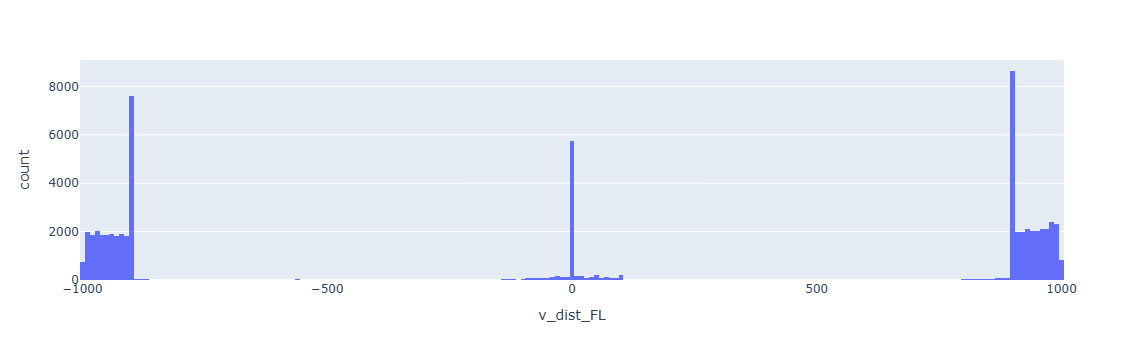

In [28]:
import plotly.express as px

px.histogram(ce_v8, x='v_dist_FL', nbins = 200)

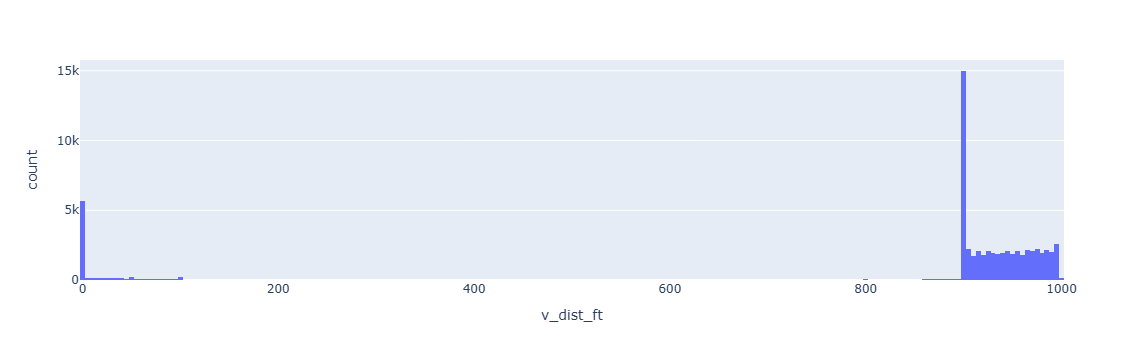

In [32]:
import plotly.express as px

px.histogram(ce_pdf[ce_pdf.v_dist_ft.apply(abs)<=999], x='v_dist_ft', nbins=200)

2240

In [8]:
ce_pdf[ce_pdf.ce_id == 'ID_273696550_ID_273696603'].sort_values('time_over')

,ce_id,ID2,ID1,time_over,h3_group,ID,lat1,lon1,time1,altitude_ft1,flight_id1,icao241,lat2,lon2,time2,altitude_ft2,flight_id2,icao242,time_diff_s,v_dist_ft,h_dist_NM,3D_dist_NM,start_time,end_time,start_3D_dist_NM,end_3D_dist_NM,start_v_dist_ft,end_v_dist_ft,start_h_dist_NM,end_h_dist_NM,min_3D_dist_NM,max_3D_dist_NM,min_v_dist_ft,max_v_dist_ft,min_h_dist_NM,max_h_dist_NM,min_3D_dist_NM_time,max_3D_dist_NM_time,min_v_dist_ft_time,max_v_dist_ft_time,min_h_dist_NM_time,max_h_dist_NM_time,is_start_time,is_end_time,is_min_3D_dist_NM,is_max_3D_dist_NM,is_min_v_dist_ft,is_max_v_dist_ft,is_min_h_dist_NM,is_max_h_dist_NM
2,ID_273696550_ID_273696603,292057777352,223338300741,2024-07-01 02:03:10,8439497ffffffff,223338300741_292057777352,40.402593,8.175278,2024-07-01 02:03:10,35000.0,ID_273696550,346082,40.466597,8.132014,2024-07-01 02:03:10,36000.0,ID_273696603,0200EF,0,1000.0,4.326406,4.329536,2024-07-01 02:03:10,2024-07-01 02:03:25,4.329536,4.529266,1000.0,1000.0,4.326406,4.526275,3.734353,4.529266,1000.0,1000.0,3.730724,4.526275,2024-07-01 02:03:15,2024-07-01 02:03:25,2024-07-01 02:03:10,2024-07-01 02:03:25,2024-07-01 02:03:15,2024-07-01 02:03:25,True,False,False,False,True,True,False,False
0,ID_273696550_ID_273696603,292057777353,223338300742,2024-07-01 02:03:15,8439493ffffffff,223338300742_292057777353,40.403333,8.161250,2024-07-01 02:03:15,35000.0,ID_273696550,346082,40.465139,8.153750,2024-07-01 02:03:15,36000.0,ID_273696603,0200EF,0,1000.0,3.730724,3.734353,2024-07-01 02:03:10,2024-07-01 02:03:25,4.329536,4.529266,1000.0,1000.0,4.326406,4.526275,3.734353,4.529266,1000.0,1000.0,3.730724,4.526275,2024-07-01 02:03:15,2024-07-01 02:03:25,2024-07-01 02:03:10,2024-07-01 02:03:25,2024-07-01 02:03:15,2024-07-01 02:03:25,False,False,True,False,True,True,True,False
1,ID_273696550_ID_273696603,292057777354,223338300743,2024-07-01 02:03:20,8439493ffffffff,223338300743_292057777354,40.404074,8.147222,2024-07-01 02:03:20,35000.0,ID_273696550,346082,40.463681,8.175486,2024-07-01 02:03:20,36000.0,ID_273696603,0200EF,0,1000.0,3.808942,3.812496,2024-07-01 02:03:10,2024-07-01 02:03:25,4.329536,4.529266,1000.0,1000.0,4.326406,4.526275,3.734353,4.529266,1000.0,1000.0,3.730724,4.526275,2024-07-01 02:03:15,2024-07-01 02:03:25,2024-07-01 02:03:10,2024-07-01 02:03:25,2024-07-01 02:03:15,2024-07-01 02:03:25,False,False,False,False,True,True,False,False
3,ID_273696550_ID_273696603,292057777355,223338300744,2024-07-01 02:03:25,8439493ffffffff,223338300744_292057777355,40.404815,8.133194,2024-07-01 02:03:25,35000.0,ID_273696550,346082,40.462222,8.197222,2024-07-01 02:03:25,36000.0,ID_273696603,0200EF,0,1000.0,4.526275,4.529266,2024-07-01 02:03:10,2024-07-01 02:03:25,4.329536,4.529266,1000.0,1000.0,4.326406,4.526275,3.734353,4.529266,1000.0,1000.0,3.730724,4.526275,2024-07-01 02:03:15,2024-07-01 02:03:25,2024-07-01 02:03:10,2024-07-01 02:03:25,2024-07-01 02:03:15,2024-07-01 02:03:25,False,True,False,True,True,True,False,True


In [ ]:
ce_pdf

In [ ]:
ce_sdf.toPandas().to_parquet('test_v10.parquet')

In [ ]:
ce = ce.find_close_encounters

In [ ]:
ce

In [25]:

parquet_path = 'data/pru_ce_20240701_1s_10FL_5NM_gtFL245_v8.parquet'
ce_v8 = spark.read.parquet(parquet_path)
ce_v8 = ce_v8.withColumn(
    "time_over",
    F.expr("time_over - interval 2 hours")
)


full_window = (
    Window
    .partitionBy("ce_id")
    .orderBy(F.col("time_over"))
    .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
)

ce_v8 = (
    ce_v8
    .withColumn(
        "ce_id",
        F.col("flight_id_concat")
    )
    # start_time_over = time_over at minimum time_over
    .withColumn(
        "start_time",
        F.first(F.col("time_over")).over(full_window)
    )
    # end_time_over = time_over at minimum time_over
    .withColumn(
        "end_time",
        F.last(F.col("time_over")).over(full_window)
    )
)





# Example usage:
# Assuming `ce_v8` is your original DataFrame:
ce_v8_expanded = add_empty_rows(
    df=ce_v8,
    id_col="ce_id",
    time_col="time_over",
    start_col="start_time",
    end_col="end_time",
    flight_id1_col='flight_id1',
    flight_id2_col='flight_id2',
    pre_seconds=600,
    post_seconds=600,
    step_seconds=1
)

def add_col_suffix(sdf, suffix: str) -> DataFrame:
    # Rename CE key to flight_id{suffix}, and all other cols to colname{suffix}
    renamed = []
    for c in sdf.columns:
        renamed.append(F.col(c).alias(f"{c}{suffix}"))
    return sdf.select(*renamed)

resampled_traj = ce.resampled_sdf

resampled_traj1 = add_col_suffix(resampled_traj, suffix = '1').withColumn('flight_id1', col('flight_id1').cast(StringType()))
resampled_traj2 = add_col_suffix(resampled_traj, suffix = '2').withColumn('flight_id2', col('flight_id2').cast(StringType()))

traj_result = ce_v8_expanded.join(resampled_traj1,
           (resampled_traj1.flight_id1 ==  ce_v8_expanded.flight_id1) &
           (resampled_traj1.time_over1 == ce_v8_expanded.time_over),
           "left").join(resampled_traj2,
           (resampled_traj2.flight_id2 ==  ce_v8_expanded.flight_id2) &
           (resampled_traj2.time_over2 == ce_v8_expanded.time_over),
           "left")

df = traj_result.toPandas()

25/07/15 23:06:47 WARN MemoryStore: Not enough space to cache rdd_51_69 in memory! (computed 11.2 MiB so far)
25/07/15 23:06:47 WARN MemoryStore: Not enough space to cache rdd_51_67 in memory! (computed 5.8 MiB so far)
25/07/15 23:06:47 WARN MemoryStore: Not enough space to cache rdd_51_65 in memory! (computed 60.4 MiB so far)
25/07/15 23:06:48 WARN MemoryStore: Not enough space to cache rdd_51_70 in memory! (computed 11.3 MiB so far)
25/07/15 23:06:48 WARN MemoryStore: Not enough space to cache rdd_51_73 in memory! (computed 22.2 MiB so far)
25/07/15 23:06:48 WARN MemoryStore: Not enough space to cache rdd_51_74 in memory! (computed 22.2 MiB so far)
25/07/15 23:06:48 WARN MemoryStore: Not enough space to cache rdd_51_72 in memory! (computed 38.5 MiB so far)
25/07/15 23:06:48 WARN MemoryStore: Not enough space to cache rdd_51_75 in memory! (computed 5.8 MiB so far)
25/07/15 23:06:49 WARN MemoryStore: Not enough space to cache rdd_51_76 in memory! (computed 11.3 MiB so far)
25/07/15 23:

In [29]:
df.to_csv('test.csv')

In [26]:
df.to_parquet('test_pru_ce_20240701_expanded_traj.parquet')

ValueError: Duplicate column names found: ['ce_id', 'flight_id1', 'flight_id2', 'time_over', 'ID2', 'ID1', 'h3_group', 'ID', 'lat1', 'lon1', 'time1', 'flight_lvl1', 'icao241', 'is_ts_interpolated1', 'lat2', 'lon2', 'time2', 'flight_lvl2', 'icao242', 'is_ts_interpolated2', 'time_diff_s', 'v_dist_FL', 'h_dist_NM', 'flight_id_concat', 'detected_by_CRIDA', 'start_time', 'end_time', 'time_over1', 'flight_level_ft1', 'latitude1', 'longitude1', 'flight_id1', 'icao241', 'is_ts_interpolated1', 'segment_id1', 'time_over2', 'flight_level_ft2', 'latitude2', 'longitude2', 'flight_id2', 'icao242', 'is_ts_interpolated2', 'segment_id2']

In [ ]:
df.sort_values

In [19]:
df.sort_values('time_over').latitude1.isna().value_counts()

latitude1
False    2745735
True       12736
Name: count, dtype: int64

In [43]:
resampled_traj1.show()

+-------------------+------------------+------------------+-------------------+----------+-------+-------------------+-----------+
|         time_over1|  flight_level_ft1|         latitude1|         longitude1|flight_id1|icao241|is_ts_interpolated1|segment_id1|
+-------------------+------------------+------------------+-------------------+----------+-------+-------------------+-----------+
|2024-07-01 00:04:58|            2340.0| 48.07838888888889| -1.783555555555556| 273696548| 3C79C9|               true|         48|
|2024-07-01 00:05:00| 2433.333333333333|48.078657407407405| -1.785694444444445| 273696548| 3C79C9|               true|         50|
|2024-07-01 00:06:52| 5786.206896551724| 48.16836206896551|-1.8158333333333343| 273696548| 3C79C9|               true|        162|
|2024-07-01 00:08:54|11666.666666666666|48.290277777777774|-1.6677777777777765| 273696548| 3C79C9|               true|        284|
|2024-07-01 00:11:22|17605.555555555555|48.500262345679005|-1.6273919753086454| 273

In [39]:
df = traj_result.toPandas()

25/07/15 21:39:13 WARN MemoryStore: Not enough space to cache rdd_51_63 in memory! (computed 60.4 MiB so far)
25/07/15 21:39:13 WARN MemoryStore: Not enough space to cache rdd_51_66 in memory! (computed 11.2 MiB so far)
25/07/15 21:39:13 WARN MemoryStore: Not enough space to cache rdd_51_67 in memory! (computed 5.8 MiB so far)
25/07/15 21:39:14 WARN MemoryStore: Not enough space to cache rdd_51_70 in memory! (computed 11.3 MiB so far)
25/07/15 21:39:14 WARN MemoryStore: Not enough space to cache rdd_51_71 in memory! (computed 60.4 MiB so far)
25/07/15 21:39:14 WARN MemoryStore: Not enough space to cache rdd_51_72 in memory! (computed 11.2 MiB so far)
25/07/15 21:39:14 WARN MemoryStore: Not enough space to cache rdd_51_73 in memory! (computed 5.8 MiB so far)
25/07/15 21:39:14 WARN MemoryStore: Not enough space to cache rdd_51_75 in memory! (computed 11.3 MiB so far)
25/07/15 21:39:15 WARN MemoryStore: Not enough space to cache rdd_51_76 in memory! (computed 5.8 MiB so far)
25/07/15 21:3

In [ ]:

df[df.ce_id == '273696741_273696990'].sort_values('time_over')

,ce_id,flight_id1,flight_id2,time_over,ID2,ID1,h3_group,ID,lat1,lon1,time1,flight_lvl1,icao241,is_ts_interpolated1,lat2,lon2,time2,flight_lvl2,icao242,is_ts_interpolated2,time_diff_s,v_dist_FL,h_dist_NM,flight_id_concat,detected_by_CRIDA,start_time,end_time,time_over1,flight_level_ft1,latitude1,longitude1,flight_id1,icao241,is_ts_interpolated1,segment_id1
83232,273696741_273696990,273696990,273696741,2024-07-01 04:20:15,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,NaT,NaN,NaN,NaN,None,None,None,NaN
142460,273696741_273696990,273696990,273696741,2024-07-01 04:20:16,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,NaT,NaN,NaN,NaN,None,None,None,NaN
25739,273696741_273696990,273696990,273696741,2024-07-01 04:20:17,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,NaT,NaN,NaN,NaN,None,None,None,NaN
22570,273696741_273696990,273696990,273696741,2024-07-01 04:20:18,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,NaT,NaN,NaN,NaN,None,None,None,NaN
60747,273696741_273696990,273696990,273696741,2024-07-01 04:20:19,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,NaT,NaN,NaN,NaN,None,None,None,NaN
91300,273696741_273696990,273696990,273696741,2024-07-01 04:20:20,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,NaT,NaN,NaN,NaN,None,None,None,NaN
75089,273696741_273696990,273696990,273696741,2024-07-01 04:20:21,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,NaT,NaN,NaN,NaN,None,None,None,NaN
32220,273696741_273696990,273696990,273696741,2024-07-01 04:20:22,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,NaT,NaN,NaN,NaN,None,None,None,NaN
94514,273696741_273696990,273696990,273696741,2024-07-01 04:20:23,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,NaT,NaN,NaN,NaN,None,None,None,NaN
129675,273696741_273696990,273696990,273696741,2024-07-01 04:20:24,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,NaT,NaN,NaN,NaN,None,None,None,NaN


In [27]:
resampled_traj.show()

+-------------------+------------------+------------------+------------------+------------+------+------------------+----------+
|          time_over|   flight_level_ft|          latitude|         longitude|   flight_id|icao24|is_ts_interpolated|segment_id|
+-------------------+------------------+------------------+------------------+------------+------+------------------+----------+
|2024-07-01 00:56:18|         13078.125| 48.70756076388888|17.455494791666663|2.73696798E8|4BD185|              true|       344|
|2024-07-01 00:56:59|           15000.0|48.701944444444436| 17.37027777777777|2.73696798E8|4BD185|             false|       385|
|2024-07-01 00:58:01|          17068.75| 48.66527777777777|17.258038194444442|2.73696798E8|4BD185|              true|       447|
|2024-07-01 00:59:42|         19709.375|48.518359374999996| 17.16828993055555|2.73696798E8|4BD185|              true|       548|
|2024-07-01 01:01:28|         23459.375| 48.35121527777777| 17.06634548611111|2.73696798E8|4BD185

In [ ]:
df[df.ce_id == '273731297_273731527'].sort_values('time_over')

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


,ce_id,flight_id1,flight_id2,time_over,ID2,ID1,h3_group,ID,lat1,lon1,time1,flight_lvl1,icao241,is_ts_interpolated1,lat2,lon2,time2,flight_lvl2,icao242,is_ts_interpolated2,time_diff_s,v_dist_FL,h_dist_NM,flight_id_concat,detected_by_CRIDA,start_time,end_time,time_over1,flight_level_ft1,latitude1,longitude1,flight_id1,icao241,is_ts_interpolated1,segment_id1
1517453,273731297_273731527,273731297,273731527,2024-07-02 01:39:33,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,2024-07-02 01:39:33,36000.0,44.475278,18.947368,273731297,4BCE09,True,3.693699e+11
468627,273731297_273731527,273731297,273731527,2024-07-02 01:39:34,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,2024-07-02 01:39:34,36000.0,44.477361,18.946645,273731297,4BCE09,True,3.693699e+11
1159394,273731297_273731527,273731297,273731527,2024-07-02 01:39:35,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,2024-07-02 01:39:35,36000.0,44.479444,18.945921,273731297,4BCE09,True,3.693699e+11
1765664,273731297_273731527,273731297,273731527,2024-07-02 01:39:36,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,2024-07-02 01:39:36,36000.0,44.481528,18.945197,273731297,4BCE09,True,3.693699e+11
110613,273731297_273731527,273731297,273731527,2024-07-02 01:39:37,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,2024-07-02 01:39:37,36000.0,44.483611,18.944474,273731297,4BCE09,True,3.693699e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482437,273731297_273731527,273731297,273731527,2024-07-02 01:59:59,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,2024-07-02 01:59:59,38000.0,46.549333,17.228000,273731297,4BCE09,True,3.693699e+11
855548,273731297_273731527,273731297,273731527,2024-07-02 02:00:00,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,2024-07-02 02:00:00,38000.0,46.550644,17.225878,273731297,4BCE09,True,3.693699e+11
2068209,273731297_273731527,273731297,273731527,2024-07-02 02:00:01,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,2024-07-02 02:00:01,38000.0,46.551956,17.223756,273731297,4BCE09,True,3.693699e+11
2593038,273731297_273731527,273731297,273731527,2024-07-02 02:00:02,NaN,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaT,NaN,None,None,NaN,NaN,NaN,None,None,NaT,NaT,2024-07-02 02:00:02,38000.0,46.553267,17.221633,273731297,4BCE09,True,3.693699e+11


In [40]:
ce_v8.toPandas()

,ID2,ID1,time_over,h3_group,ID,lat1,lon1,time1,flight_lvl1,flight_id1,...,icao242,is_ts_interpolated2,time_diff_s,v_dist_FL,h_dist_NM,flight_id_concat,detected_by_CRIDA,ce_id,start_time,end_time
0,360777754717,171798713413,2024-07-01 09:32:04,841e035ffffffff,171798713413_360777754717,47.289444,18.018611,2024-07-01 09:32:04,38000.000000,273696656,...,407D5C,True,0,962.500000,4.847630,273696656_273700799,True,273696656_273700799,2024-07-01 09:32:04,2024-07-01 09:32:04
1,360777754718,171798713414,2024-07-01 09:32:05,841e023ffffffff,171798713414_360777754718,47.290113,18.015634,2024-07-01 09:32:05,38000.000000,273696656,...,407D5C,True,0,959.375000,4.623943,273696656_273700799,True,273696656_273700799,2024-07-01 09:32:04,2024-07-01 09:32:04
2,360777754719,171798713415,2024-07-01 09:32:06,841e035ffffffff,171798713415_360777754719,47.290781,18.012656,2024-07-01 09:32:06,38000.000000,273696656,...,407D5C,True,0,956.250000,4.403743,273696656_273700799,True,273696656_273700799,2024-07-01 09:32:04,2024-07-01 09:32:04
3,360777754720,171798713416,2024-07-01 09:32:07,841e035ffffffff,171798713416_360777754720,47.291450,18.009679,2024-07-01 09:32:07,38000.000000,273696656,...,407D5C,True,0,953.125000,4.187581,273696656_273700799,True,273696656_273700799,2024-07-01 09:32:04,2024-07-01 09:32:04
4,360777754721,171798713417,2024-07-01 09:32:08,841e035ffffffff,171798713417_360777754721,47.292118,18.006701,2024-07-01 09:32:08,38000.000000,273696656,...,407D5C,True,0,950.000000,3.976116,273696656_273700799,True,273696656_273700799,2024-07-01 09:32:04,2024-07-01 09:32:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63575,755916376486,360779711785,2024-07-02 04:08:56,842b203ffffffff,360779711785_755916376486,47.237840,-61.205093,2024-07-02 04:08:56,37988.888889,273730410,...,A8C121,True,0,988.888889,3.634587,273730410_273731094,False,273730410_273731094,2024-07-02 04:07:37,2024-07-02 04:07:37
63576,755916376487,360779711786,2024-07-02 04:08:57,842b239ffffffff,360779711786_755916376487,47.239660,-61.201907,2024-07-02 04:08:57,37991.111111,273730410,...,A8C121,True,0,991.111111,3.659113,273730410_273731094,False,273730410_273731094,2024-07-02 04:07:37,2024-07-02 04:07:37
63577,755916376488,360779711787,2024-07-02 04:08:58,842b207ffffffff,360779711787_755916376488,47.241481,-61.198722,2024-07-02 04:08:58,37993.333333,273730410,...,A8C121,True,0,993.333333,3.683639,273730410_273731094,False,273730410_273731094,2024-07-02 04:07:37,2024-07-02 04:07:37
63578,755916376489,360779711788,2024-07-02 04:08:59,842b239ffffffff,360779711788_755916376489,47.243302,-61.195537,2024-07-02 04:08:59,37995.555556,273730410,...,A8C121,True,0,995.555556,3.708167,273730410_273731094,False,273730410_273731094,2024-07-02 04:07:37,2024-07-02 04:07:37


In [37]:
df[df.ID1.isna()]

,ce_id,time_over,ID2,ID1,h3_group,ID,lat1,lon1,time1,flight_lvl1,...,flight_id2,icao242,is_ts_interpolated2,time_diff_s,v_dist_FL,h_dist_NM,flight_id_concat,detected_by_CRIDA,start_time,end_time


In [22]:
traj_sdf = ce.resampled_sdf

In [31]:
from pyspark.sql import DataFrame, functions as F


def join_ce_with_both_trajs(
    ce_df: DataFrame,
    traj_df: DataFrame,
    ce_start_col: str = "start_time",
    ce_end_col: str = "end_time",
    fid1_col: str = "flight_id1",
    fid2_col: str = "flight_id2",
    traj_id_col: str = "flight_id",
    traj_time_col: str = "time_over",
    window_minutes: int = 10,
) -> DataFrame:
    """
    For each conflict‐event (CE) row, attach all trajectory points for
    flight_id1 (“1”) and flight_id2 (“2”), taken ±window_minutes around
    the CE window.

    Args:
        ce_df: Spark DataFrame of conflict events.
        traj_df: Spark DataFrame of trajectories.
        ce_start_col: CE window start‐time column.
        ce_end_col: CE window end‐time column.
        fid1_col: first‐flight ID column in ce_df.
        fid2_col: second‐flight ID column in ce_df.
        traj_id_col: flight‐ID column in traj_df.
        traj_time_col: trajectory timestamp column.
        window_minutes: minutes padding before/after CE window.

    Returns:
        DataFrame: CE×traj1×traj2, with columns
          – all ce_df columns (as is),
          – trajectory columns suffixed “1”,
          – trajectory columns suffixed “2”.
    """
    # Interval literal for padding
    interval_expr = f"INTERVAL {window_minutes} MINUTES"

    # 1) Prepare trajectories for side “1”
    traj1 = (
        traj_df
        .select(
            F.col(traj_id_col).alias(f"{traj_id_col}1"),
            F.col(traj_time_col).alias(f"{traj_time_col}1"),
            F.col("flight_level_ft").alias("flight_level_ft1"),
            F.col("latitude").alias("latitude1"),
            F.col("longitude").alias("longitude1"),
            F.col("icao24").alias("icao241"),
            F.col("is_ts_interpolated").alias("is_ts_interpolated1"),
            F.col("segment_id").alias("segment_id1"),
        )
    )

    # 2) Join CE → traj1, using aliases to avoid ambiguity
    ce_alias = ce_df.alias("ce")
    t1_alias = traj1.alias("t1")
    cond1 = (
        (F.col(f"ce.{fid1_col}") == F.col(f"t1.{traj_id_col}1"))
        & F.col(f"t1.{traj_time_col}1").between(
            F.col(f"ce.{ce_start_col}") - F.expr(interval_expr),
            F.col(f"ce.{ce_end_col}") + F.expr(interval_expr),
        )
    )
    ce_t1 = ce_alias.join(t1_alias, cond1, how="left")

    # 3) Prepare trajectories for side “2”
    traj2 = (
        traj_df
        .select(
            F.col(traj_id_col).alias(f"{traj_id_col}2"),
            F.col(traj_time_col).alias(f"{traj_time_col}2"),
            F.col("flight_level_ft").alias("flight_level_ft2"),
            F.col("latitude").alias("latitude2"),
            F.col("longitude").alias("longitude2"),
            F.col("icao24").alias("icao242"),
            F.col("is_ts_interpolated").alias("is_ts_interpolated2"),
            F.col("segment_id").alias("segment_id2"),
        )
    )

    # 4) Join that result → traj2, again with aliases
    t2_alias = traj2.alias("t2")
    cond2 = (
        (F.col(f"ce.{fid2_col}") == F.col(f"t2.{traj_id_col}2"))
        & F.col(f"t2.{traj_time_col}2").between(
            F.col(f"ce.{ce_start_col}") - F.expr(interval_expr),
            F.col(f"ce.{ce_end_col}") + F.expr(interval_expr),
        )
    )
    final_df = ce_t1.join(t2_alias, cond2, how="left")

    return final_df


# Usage example:
joined = join_ce_with_both_trajs(ce_v8, traj_sdf, window_minutes=10)
joined.printSchema()
joined.show(5)


root
 |-- ID2: long (nullable = true)
 |-- ID1: long (nullable = true)
 |-- time_over: timestamp (nullable = true)
 |-- h3_group: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- lat1: double (nullable = true)
 |-- lon1: double (nullable = true)
 |-- time1: timestamp (nullable = true)
 |-- flight_lvl1: double (nullable = true)
 |-- flight_id1: string (nullable = true)
 |-- icao241: string (nullable = true)
 |-- is_ts_interpolated1: boolean (nullable = true)
 |-- lat2: double (nullable = true)
 |-- lon2: double (nullable = true)
 |-- time2: timestamp (nullable = true)
 |-- flight_lvl2: double (nullable = true)
 |-- flight_id2: string (nullable = true)
 |-- icao242: string (nullable = true)
 |-- is_ts_interpolated2: boolean (nullable = true)
 |-- time_diff_s: integer (nullable = true)
 |-- v_dist_FL: double (nullable = true)
 |-- h_dist_NM: double (nullable = true)
 |-- flight_id_concat: string (nullable = true)
 |-- detected_by_CRIDA: boolean (nullable = true)
 |-- ce_id:

25/07/15 19:31:54 WARN MemoryStore: Not enough space to cache rdd_53_55 in memory! (computed 13.7 MiB so far)
25/07/15 19:31:54 WARN MemoryStore: Not enough space to cache rdd_53_53 in memory! (computed 27.1 MiB so far)
25/07/15 19:31:54 WARN MemoryStore: Not enough space to cache rdd_53_57 in memory! (computed 7.1 MiB so far)
25/07/15 19:31:54 WARN MemoryStore: Not enough space to cache rdd_53_58 in memory! (computed 7.1 MiB so far)
25/07/15 19:31:54 WARN MemoryStore: Not enough space to cache rdd_53_59 in memory! (computed 7.1 MiB so far)
25/07/15 19:31:55 WARN MemoryStore: Not enough space to cache rdd_53_60 in memory! (computed 27.1 MiB so far)
25/07/15 19:31:55 WARN MemoryStore: Not enough space to cache rdd_53_61 in memory! (computed 13.7 MiB so far)
25/07/15 19:31:55 WARN MemoryStore: Not enough space to cache rdd_53_62 in memory! (computed 27.1 MiB so far)
25/07/15 19:31:55 WARN MemoryStore: Not enough space to cache rdd_53_63 in memory! (computed 13.7 MiB so far)
25/07/15 19:3

+------------+------------+-------------------+---------------+--------------------+------------------+------------------+-------------------+-----------+----------+-------+-------------------+------------------+------------------+-------------------+-----------+----------+-------+-------------------+-----------+---------+-----------------+-------------------+-----------------+-------------------+-------------------+-------------------+----------+----------+----------------+---------+----------+-------+-------------------+-----------+----------+----------+----------------+---------+----------+-------+-------------------+-----------+
|         ID2|         ID1|          time_over|       h3_group|                  ID|              lat1|              lon1|              time1|flight_lvl1|flight_id1|icao241|is_ts_interpolated1|              lat2|              lon2|              time2|flight_lvl2|flight_id2|icao242|is_ts_interpolated2|time_diff_s|v_dist_FL|        h_dist_NM|   flight_id_conc

%%time
# Find close encounters
ce_sdf = ce.find_close_encounters(
    h_dist_NM=h_dist_NM,
    v_dist_ft=v_dist_ft,
    v_cutoff_FL=v_cutoff_FL,
    freq_s=freq_s,
    t_max=t_max,
    method = 'brute_force'
)

# Convert from a Spark DataFrame (sdf) to Pandas Dataframe (pdf)
ce_pdf_bf = ce_sdf

print(ce_pdf_bf.shape)

In [7]:
%%time
# Find close encounters
ce_duckdb = ce.find_close_encounters_duckdb(
    h_dist_NM=h_dist_NM,
    v_dist_ft=v_dist_ft,
    v_cutoff_FL=v_cutoff_FL,
    freq_s=freq_s,
    t_max=t_max
)

print(ce_duckdb.shape)


[2025-06-27 17:29:30,025] INFO - Starting DuckDB-based detection (1:1 with Spark).
[2025-06-27 17:29:30,026] INFO - Skipping resample: already done (freq_s=5, t_max=10)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[2025-06-27 17:32:36,599] INFO - DuckDB (1:1 Spark) found 242534 encounters


(242534, 12)
CPU times: user 8min 37s, sys: 1min 44s, total: 10min 22s
Wall time: 3min 13s


In [13]:
ce_duckdb["ID_combined"] = ce_duckdb["ID1"].astype(str).str.cat(ce_duckdb["ID2"].astype(str), sep="_")

In [14]:
ce_duckdb['isin_spark'] = ce_duckdb.ID_combined.isin(ce_pdf_half_disk.ID.to_list())

In [16]:
ce_duckdb[ce_duckdb['isin_spark'] == False]

,time_over,ID1,ID2,lat1,lon1,altitude_ft1,flight_id1,lat2,lon2,altitude_ft2,flight_id2,h_dist_NM,ID_combined,isin_spark
92112,2024-07-01 13:15:10,309237931563,532576201785,65.502611,-11.325444,35000.00,273714416.0,65.471611,-11.299778,34000.00,273713939.0,1.970174,309237931563_532576201785,False
114431,2024-07-01 13:15:00,309237931561,532576201783,65.488111,-11.284111,35000.00,273714416.0,65.456556,-11.257056,34000.00,273713939.0,2.013255,309237931561_532576201783,False
132444,2024-07-01 09:30:40,128849261916,618475446304,40.703611,16.594537,32933.33,273711156.0,40.743333,16.557130,31933.33,273705871.0,2.933274,128849261916_618475446304,False
200873,2024-07-01 13:15:05,309237931562,532576201784,65.495361,-11.304778,35000.00,273714416.0,65.464083,-11.278417,34000.00,273713939.0,1.991682,309237931562_532576201784,False


25/06/27 22:28:57 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 949853 ms exceeds timeout 120000 ms
25/06/27 22:28:57 WARN SparkContext: Killing executors is not supported by current scheduler.
25/06/27 22:29:01 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [15]:
ce_pdf_half_disk.altitude_ft1.values[0]

np.float64(37000.0)

In [12]:
%%time
# Find close encounters
ce_sdf = ce.find_close_encounters(
    h_dist_NM=h_dist_NM,
    v_dist_ft=v_dist_ft,
    v_cutoff_FL=v_cutoff_FL,
    freq_s=freq_s,
    t_max=t_max,
    method = 'half_disk'
)

# Convert from a Spark DataFrame (sdf) to Pandas Dataframe (pdf)
ce_pdf_half_disk = ce_sdf.toPandas()

print(ce_pdf_half_disk.shape)

[2025-06-27 17:49:54,539] INFO - Starting close encounter detection with method='half_disk'
[2025-06-27 17:49:54,539] INFO - Skipping resample: already done (freq_s=5, t_max=10)
[2025-06-27 17:55:18,620] INFO - Found 242530 candidate close encounters        


(242530, 20)
CPU times: user 10.6 s, sys: 503 ms, total: 11.1 s
Wall time: 5min 34s


In [ ]:
%%time
# Find close encounters
ce_sdf = ce.find_close_encounters_duckdb(
    h_dist_NM=h_dist_NM,
    v_dist_ft=v_dist_ft,
    v_cutoff_FL=v_cutoff_FL,
    freq_s=freq_s,
    t_max=t_max
)

print(ce_sdf.shape)


[2025-06-27 01:26:17,217] INFO - Starting DuckDB-based detection (1:1 with Spark).
[2025-06-27 01:26:17,217] INFO - Skipping resample: already done (freq_s=1, t_max=10)
25/06/27 01:26:24 WARN MemoryStore: Not enough space to cache rdd_53_50 in memory! (computed 27.1 MiB so far)
25/06/27 01:26:24 WARN MemoryStore: Not enough space to cache rdd_53_52 in memory! (computed 13.7 MiB so far)
25/06/27 01:26:24 WARN MemoryStore: Not enough space to cache rdd_53_53 in memory! (computed 7.1 MiB so far)
25/06/27 01:26:25 WARN MemoryStore: Not enough space to cache rdd_53_56 in memory! (computed 27.1 MiB so far)
25/06/27 01:26:25 WARN MemoryStore: Not enough space to cache rdd_53_57 in memory! (computed 13.7 MiB so far)
25/06/27 01:26:26 WARN MemoryStore: Not enough space to cache rdd_53_61 in memory! (computed 27.1 MiB so far)
25/06/27 01:26:26 WARN MemoryStore: Not enough space to cache rdd_53_62 in memory! (computed 13.7 MiB so far)
25/06/27 01:26:26 WARN MemoryStore: Not enough space to cache 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

OutOfMemoryException: Out of Memory Error: failed to offload data block of size 256.0 KiB (499.9 GiB/500.0 GiB used).
This limit was set by the 'max_temp_directory_size' setting.
By default, this setting utilizes the available disk space on the drive where the 'temp_directory' is located.
You can adjust this setting, by using (for example) PRAGMA max_temp_directory_size='10GiB'

Possible solutions:
* Reducing the number of threads (SET threads=X)
* Disabling insertion-order preservation (SET preserve_insertion_order=false)
* Increasing the memory limit (SET memory_limit='...GB')

See also https://duckdb.org/docs/stable/guides/performance/how_to_tune_workloads

In [9]:
import math
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, udf
from pyspark.sql.types import DoubleType

def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calculate the initial bearing (forward azimuth) between two points
    specified in decimal degrees using the great-circle formula.

    Parameters:
        lat1 (float): Latitude of the first point.
        lon1 (float): Longitude of the first point.
        lat2 (float): Latitude of the second point.
        lon2 (float): Longitude of the second point.

    Returns:
        float: Initial bearing in degrees, normalized to [0, 360).
    """
    if None in (lat1, lon1, lat2, lon2):
        return None

    lat1_rad = math.radians(lat1)
    lat2_rad = math.radians(lat2)
    delta_lon_rad = math.radians(lon2 - lon1)

    x = math.sin(delta_lon_rad) * math.cos(lat2_rad)
    y = (math.cos(lat1_rad) * math.sin(lat2_rad) -
         math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon_rad))

    bearing_rad = math.atan2(x, y)
    bearing_deg = math.degrees(bearing_rad)

    return (bearing_deg + 360) % 360


# Register UDF
calculate_bearing_udf = udf(calculate_bearing, DoubleType())

# Assume `resampled_sdf` is your existing DataFrame
# Define window for each flight ordered by timestamp
window_spec = Window.partitionBy("flight_id").orderBy("time_over")

# Add previous point's latitude and longitude
resampled_sdf = resampled_sdf.withColumn(
    "prev_latitude", lag("latitude").over(window_spec)
)
resampled_sdf = resampled_sdf.withColumn(
    "prev_longitude", lag("longitude").over(window_spec)
)

# Compute heading using the UDF
resampled_sdf = resampled_sdf.withColumn(
    "heading",
    calculate_bearing_udf(
        col("prev_latitude"),
        col("prev_longitude"),
        col("latitude"),
        col("longitude")
    )
)


In [10]:
resampled_pdf = resampled_sdf.limit(20000).toPandas()

In [11]:
resampled_pdf

,time_over,flight_level,latitude,longitude,flight_id,icao24,is_ts_interpolated,segment_id,prev_latitude,prev_longitude,heading
0,2024-07-01 12:00:15,370.0,65.029722,-6.206111,273696561.0,3965AF,False,1432,NaN,NaN,NaN
1,2024-07-01 12:00:20,370.0,65.020000,-6.200083,273696561.0,3965AF,True,1433,65.029722,-6.206111,165.327592
2,2024-07-01 12:00:25,370.0,65.010278,-6.194056,273696561.0,3965AF,True,1434,65.020000,-6.200083,165.322479
3,2024-07-01 12:00:30,370.0,65.000556,-6.188028,273696561.0,3965AF,True,1435,65.010278,-6.194056,165.317367
4,2024-07-01 12:00:35,370.0,64.990833,-6.182000,273696561.0,3965AF,True,1436,65.000556,-6.188028,165.312255
...,...,...,...,...,...,...,...,...,...,...,...
19995,2024-07-01 13:32:10,380.0,41.479722,41.306111,273697355.0,4406DE,False,26171,41.478148,41.321343,277.858780
19996,2024-07-01 13:32:15,380.0,41.481065,41.292917,273697355.0,4406DE,True,26172,41.479722,41.306111,277.738986
19997,2024-07-01 13:32:20,380.0,41.482407,41.279722,273697355.0,4406DE,True,26173,41.481065,41.292917,277.739145
19998,2024-07-01 13:32:25,380.0,41.483750,41.266528,273697355.0,4406DE,True,26174,41.482407,41.279722,277.739303


In [15]:
!pip uninstall -f plotly


Usage:   
  pip uninstall [options] <package> ...
  pip uninstall [options] -r <requirements file> ...

no such option: -f


In [9]:
import plotly.express as px
px.scatter(resampled_pdf, x = 'lat', y = 'lon')

ModuleNotFoundError: No module named 'plotly'

In [ ]:
ce.

In [10]:
ce = ce.find_close_encounters()

Skipping resample: Already done (w. freq_s = 5 and t_max = 10)


In [11]:
ce.show()

+-----------+----------+-------------------+---------------+--------------------+------------------+------------------+-------------------+------------------+------------+-------+------------------+------------------+-------------------+-----------------+------------+-------+-----------+------------------+------------------+
|        ID2|       ID1|          time_over|       h3_group|                  ID|              lat1|              lon1|              time1|       flight_lvl1|  flight_id1|icao241|              lat2|              lon2|              time2|      flight_lvl2|  flight_id2|icao242|time_diff_s|         v_dist_FL|         h_dist_NM|
+-----------+----------+-------------------+---------------+--------------------+------------------+------------------+-------------------+------------------+------------+-------+------------------+------------------+-------------------+-----------------+------------+-------+-----------+------------------+------------------+
|     869136|    57

In [12]:
df = load_sample_trajectories()
encounters_df = CloseEncountersH3HalfDisk(
    df, 
    distance_nm = horizontal_separation_NM, 
    FL_diff = vertical_separation_FL, 
    FL_min = minimal_FL, 
    deltaT_min = deltaT_min, 
    pnumb = 100, 
    spark = spark)

NameError: name 'CloseEncountersH3HalfDisk' is not defined

In [ ]:
create_keplergl_html(encounters_df)

TypeError: CloseEncounters.__init__() missing 1 required positional argument: 'spark'